# Sentiment Analysis - IMDb Reviews

Imports 

In [1]:
import re
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

NLTK Setup

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zezoe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zezoe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zezoe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load Dataset

In [ ]:
df = pd.read_csv('Dataset/IMDB Dataset.csv')

Text Preprocessing

In [ ]:
def preprocess_text(text):
    text = re.sub('<.*?>', '', text)          # Remove HTML tags
    text = re.sub('[^a-zA-Z]', ' ', text)     # Keep only letters
    text = text.lower()                        # Lowercase
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df['clean_review'] = df['review'].apply(preprocess_text)

Exploratory Visualization

C:\Users\zezoe\AppData\Local\Temp\ipykernel_8132\3159588927.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette='Set2')


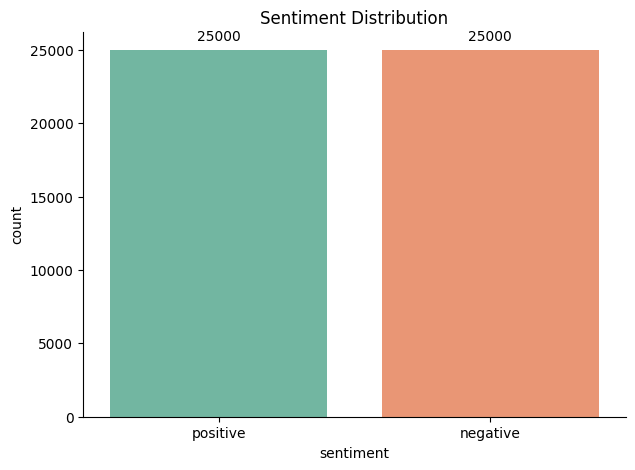

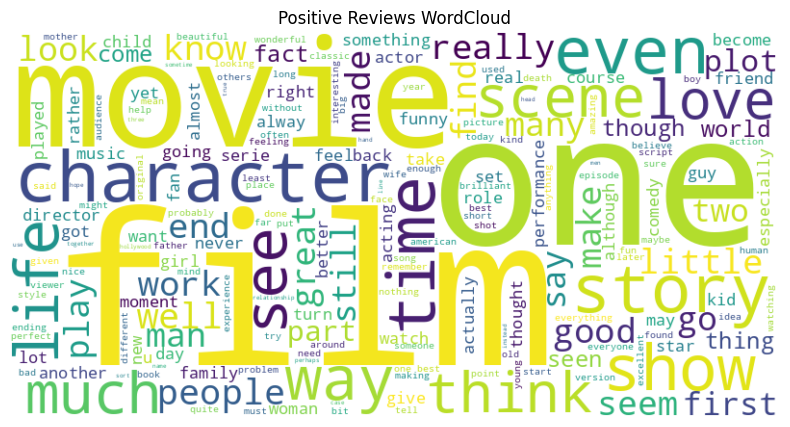

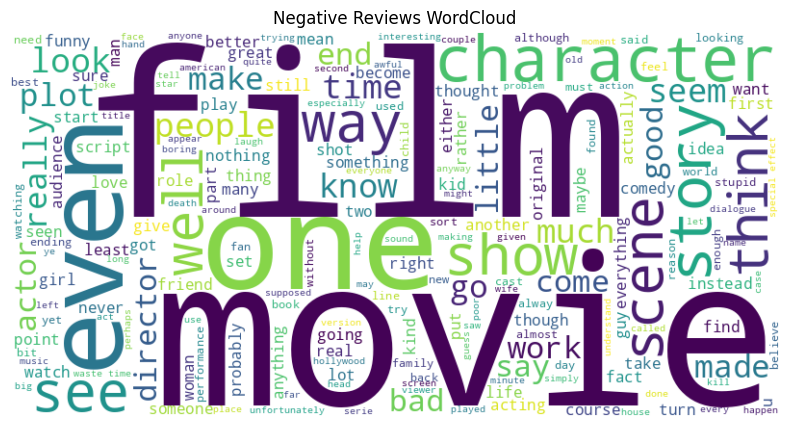

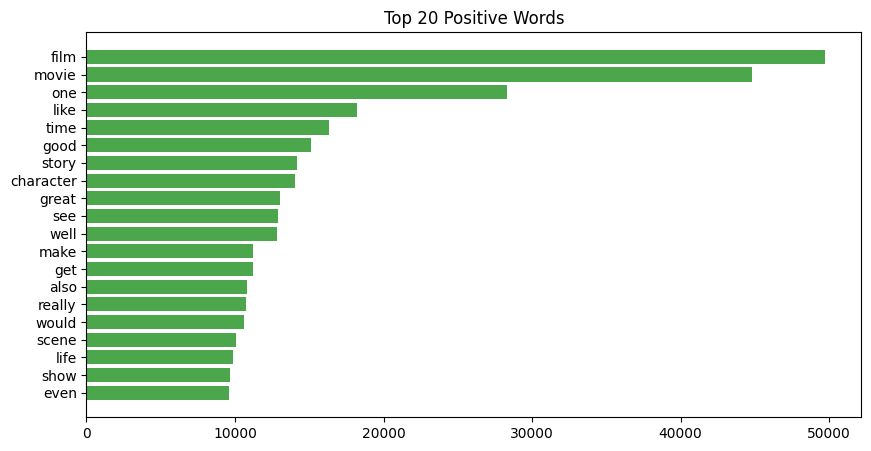

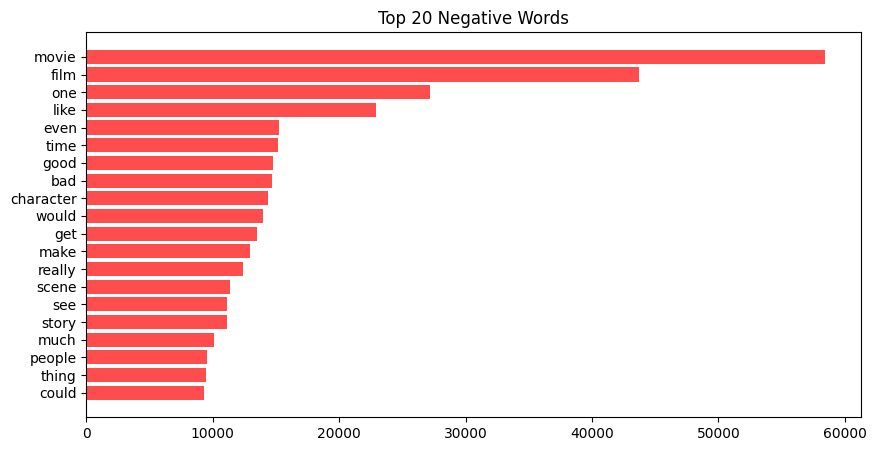

In [3]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine()
plt.show()

# WordClouds
def plot_wordcloud(text, title, color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=color).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(' '.join(df[df['sentiment']=='positive']['clean_review']), 'Positive Reviews WordCloud', 'white')
plot_wordcloud(' '.join(df[df['sentiment']=='negative']['clean_review']), 'Negative Reviews WordCloud', 'white')

# Top frequent words barplots
def plot_top_words(df, sentiment, top_n=20):
    words = ' '.join(df[df['sentiment']==sentiment]['clean_review']).split()
    freq = Counter(words).most_common(top_n)
    words, counts = zip(*freq)
    plt.figure(figsize=(10,5))
    plt.barh(words, counts, color='green' if sentiment=='positive' else 'red', alpha=0.7)
    plt.title(f'Top {top_n} {sentiment.capitalize()} Words')
    plt.gca().invert_yaxis()
    plt.show()

plot_top_words(df, 'positive')
plot_top_words(df, 'negative')


Feature Extraction

In [4]:
X = df['clean_review']
y = df['sentiment']

tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

Model Training

In [6]:
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Evaluation

--- Logistic Regression ---
Accuracy: 0.88
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



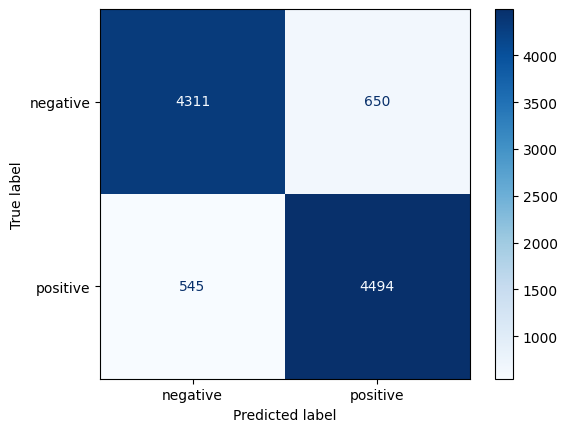

--- Naive Bayes ---
Accuracy: 0.85
              precision    recall  f1-score   support

    negative       0.85      0.84      0.84      4961
    positive       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



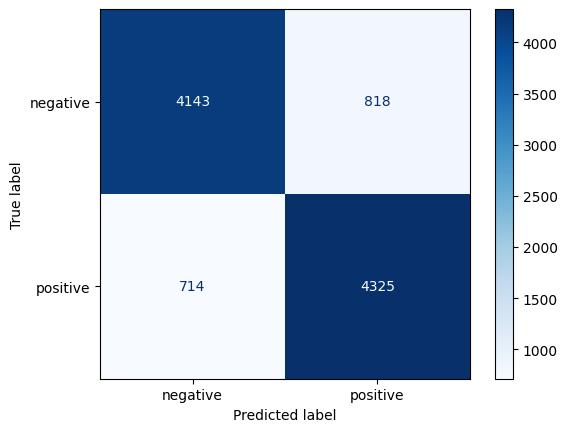

In [7]:
def evaluate_model(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.show()

evaluate_model(log_model, X_test, y_test, 'Logistic Regression')
evaluate_model(nb_model, X_test, y_test, 'Naive Bayes')

Prediction Function

In [8]:
def predict_sentiment(text, model_choice='logistic'):
    text_clean = preprocess_text(text)
    vect_text = tfidf_vectorizer.transform([text_clean])
    if model_choice == 'logistic':
        return log_model.predict(vect_text)[0]
    elif model_choice == 'naive_bayes':
        return nb_model.predict(vect_text)[0]
    else:
        raise ValueError('Choose "logistic" or "naive_bayes"')

Save Models

In [9]:
pickle.dump(log_model, open('model_logistic.pkl', 'wb'))
pickle.dump(nb_model, open('model_nb.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open('vectorizer.pkl', 'wb'))

BONUS

# BONUS 1: Top 20 TF-IDF Words
sum_tfidf = X_tfidf.sum(axis=0)
tfidf_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
tfidf_freq = sorted(tfidf_freq, key=lambda x: x[1], reverse=True)[:20]
words_tfidf, freqs_tfidf = zip(*tfidf_freq)

plt.figure(figsize=(10,5))
plt.bar(words_tfidf, freqs_tfidf, color='salmon')
plt.xticks(rotation=45)
plt.title('Top 20 Words by TF-IDF (Bonus)')
plt.ylabel('TF-IDF Score')
plt.tight_layout()
plt.show()

In [ ]:
# BONUS 2: WordCloud using top TF-IDF words
top_words_dict = dict(tfidf_freq)
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Top TF-IDF Words (Bonus)')
plt.show()